In [1]:
import math 
import random 
import cv2
from PIL import Image
import pickle
import imageio
import cv2
import kornia as K
import kornia.geometry as KG
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from numpy.linalg import inv

In [438]:
with open('10frame.pickle', 'rb') as f:
    rec = pickle.load(f)

In [439]:
# im1 = cv2.imread(r'C:\Users\28340\Documents\UCL\finalYearProject\code\rgb_out\002.png')
im1 = cv2.cvtColor(cv2.imread(r'C:\Users\28340\Documents\UCL\finalYearProject\code\rgb_out\002.png'), cv2.COLOR_BGR2RGB)
# im2 = cv2.imread(r'C:\Users\28340\Documents\UCL\finalYearProject\code\rgb_out\010.png')
im2 = cv2.cvtColor(cv2.imread(r'C:\Users\28340\Documents\UCL\finalYearProject\code\rgb_out\010.png'), cv2.COLOR_BGR2RGB)
intrinsic = rec['intrinsic']
extrinsic1 = inv(np.array([[0,1,0,0],[0,0,-1,0],[1,0,0,0],[0,0,0,1]]))@rec['extrinsic'][1]
extrinsic2 = inv(np.array([[0,1,0,0],[0,0,-1,0],[1,0,0,0],[0,0,0,1]]))@rec['extrinsic'][9]
position1 = rec['position'][1]
position2 = rec['position'][9]
depth1 = rec['depth'][1]
depth2 = rec['depth'][9]
transfrom1 = rec['get_transfrom'][1]
transfrom2 = rec['get_transfrom'][9]

In [440]:
def get_grid(x, y, homogenous=False):
    coords = np.indices((x, y)).reshape(2, -1)
    return np.vstack((coords, np.ones(coords.shape[1]))) if homogenous else coords

In [441]:
# #Assume no distortion, inverse intrinsic matrix
# intrinsic_inv = np.linalg.inv(intrinsic)

# def image_inv_intrinsic(image,K):
#     I = np.linalg.inv(K)
#     height, width = image.shape[:2]
#     coords = get_grid(width, height, True)
#     x2, y2 = coords[0], coords[1]
#     # Apply inverse transform and round it (nearest neighbour interpolation)
#     warp_coords = (I@coords).astype(np.int_)
#     x1, y1 = warp_coords[0, :], warp_coords[1, :]
#     # Get pixels within image boundaries
#     indices = np.where((x1 >= 0) & (x1 < width) &
#                     (y1 >= 0) & (y1 < height))
#     xpix1, ypix1 = x2[indices], y2[indices]
#     xpix2, ypix2 = x1[indices], y1[indices]
#     result = np.zeros_like(image)
#     result[ypix1.astype(int), xpix1.astype(int)] = image[ypix2,xpix2]
#     return result

In [442]:
# # im1_Iinversed = image_inv_intrinsic(im1,intrinsic)
# # im2_Inversed = image_inv_intrinsic(im2,intrinsic)
# im1_Iinversed = cv2.warpPerspective(im1, intrinsic_inv, (im1.shape[1], im1.shape[0]))
# im2_Inversed = cv2.warpPerspective(im2, intrinsic_inv, (im2.shape[1], im2.shape[0]))



In [443]:
# image1_depth =im1_Iinversed**depth1
# image1_depth =np.concatenate([image1_depth,depth1], axis=-1)
# image2_depth =im2_Inversed**depth2
# image2_depth =np.concatenate([image2_depth,depth2], axis=-1)

In [444]:
extrinsic1
rotation1 = extrinsic1[:3,:3]
translation1 = extrinsic1[:3,3]
extrinsic2
rotation2 = extrinsic2[:3,:3]

$x =  \frac{\phi_{x} u+ \gamma u}{w} + \delta_x$

$u = \frac{(x-\delta_x)w}{\phi_x+\gamma}$

In [527]:
depth1.shape

(600, 800, 4)

In [539]:
# 2d image to 3D point, inversed intrinsic matrix
def image_to_point(image, intrinsic, depth_image):
    height, width = depth_image.shape[:2]
    fx = intrinsic[0,0]
    fy = intrinsic[1,1]
    cx = intrinsic[0,2]
    cy = intrinsic[1,2]
    skew = intrinsic[0,1]

    point1 = []
    color1 = []
    height, width = depth_image.shape[:2]
    for i in range(height):
        for j in range(width):
            R = depth_image[i,j,0]
            G = depth_image[i,j,1]
            B = depth_image[i,j,2]
            z =  (R + G * 256 + B * 256 * 256)*1000.0 / ((256 * 256 * 256 - 1))
            if z>100:
                z = 0
            x = ((i -cx)*z)/(fx+skew)
            y = ((j -cy)*z)/fy
            # x = i
            # y = j

            point1.append([x, y, z])

            # if 0 <= x < width and 0 <= y < height:
            color1.append(image[i][j] / 255)
            # else:
            #     color1.append([0., 0., 0.])
    return np.array(point1),np.array(color1)

In [446]:
point1,color1 = image_to_point(im1, intrinsic, depth1)
point2,color2 = image_to_point(im2, intrinsic, depth2)

In [447]:
import open3d as o3d
pcd_o3d = o3d.geometry.PointCloud()  
pcd_o3d.points = o3d.utility.Vector3dVector(pointC)  
pcd_o3d.colors = o3d.utility.Vector3dVector(color1)  
# Visualize:
o3d.visualization.draw_geometries([pcd_o3d])

In [448]:
# inverse extrinsic
def inverse_E_point(point,extrinsic):
    if type(point) != np.ndarray:

        temp_p = torch.concat([point,torch.ones(point.shape[0],1).to('cuda')],dim=1)
        inv_p = torch.inverse(extrinsic)@temp_p.T
        return inv_p[:3,:].T

    temp_p = np.concatenate([point, np.ones((point.shape[0], 1))], axis=1)
    inv_point = np.linalg.inv(extrinsic)@temp_p.T
    return inv_point.T[:, :3]

In [449]:
def point_to_image(point, intrinsic,height,width,color):
    perspective_projection = point/(point[:,[-1]])
    print(perspective_projection.shape)
    projected_points = (intrinsic@perspective_projection.T).T
    image = projected_points[:, :2]
    rgbimage = np.zeros((height,width,3))
    for i in range(image.shape[0]):
        try:
            rgbimage[image[i,0].astype(int),image[i,1].astype(int),:] = color[i]
        except:
            # print("image[{}]".format(i),image[i])
            continue
    
    return image,rgbimage

In [450]:
point_Einverse1 = inverse_E_point(point1,extrinsic1)
# test u' could be find by using u 
point2_projected = extrinsic2@np.concatenate([point_Einverse1, np.ones((point_Einverse1.shape[0], 1))], axis=1).T
point2_projected = point2_projected.T[:, :3]
point_C_inverseE_projected,colorC_projected = point_to_image(point2_projected,intrinsic,height=im2.shape[0],width = im2.shape[1],color =color2)


(480000, 3)


In [491]:
point1,color1 = image_to_point(im1, intrinsic, depth1)
point_1_inverseE = inverse_E_point(point1,extrinsic1)
point_1_project = extrinsic2@np.concatenate([point_1_inverseE, np.ones((point_1_inverseE.shape[0], 1))], axis=1).T
point_1_project = point_1_project.T[:, :3]
point_1_inverseE_projected,color1_projected = point_to_image(point_1_project,intrinsic,height=im2.shape[0],width = im2.shape[1],color =color2)


(480000, 3)


In [498]:
#train for Tqr with known 2 extrinsic matrix

Tqr = torch.eye(4)
Tqr.requires_grad = True

optimizer = torch.optim.Adam([Tqr], lr=0.05)
for epoch in range(1000):
    # print("epoch:",epoch)
    loss = torch.sum((torch.tensor(extrinsic2,dtype=torch.float32,requires_grad=False)-Tqr@torch.tensor(extrinsic1,dtype=torch.float32,requires_grad=False))**2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [499]:
Tqr

tensor([[ 0.9717,  0.0716, -0.0111, -0.5780],
        [-0.0118,  0.9987,  0.0035,  0.0128],
        [ 0.0150, -0.0026,  0.9999, -0.0051],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], requires_grad=True)

In [505]:
#plot projected im1 to im2

tempq2 = (Tqr.detach().cpu().numpy()@(np.concatenate([point1, np.ones((point1.shape[0], 1))], axis=1).T)).T
tempq2 = tempq2[:, :3]/tempq2[:, [-1]]
tempp2Image,tempp2Image_color= point_to_image(tempq2,intrinsic,height=im2.shape[0],width = im2.shape[1],color =color2)

(480000, 3)


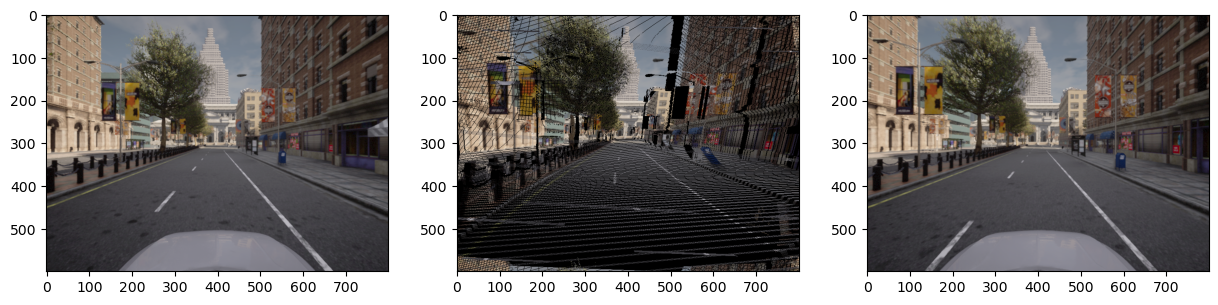

In [506]:
fig,ax = plt.subplots(1,3,figsize=(15,15))
ax[1].imshow(tempp2Image_color)
ax[2].imshow(im2)
ax[0].imshow(im1)

In [546]:
#train for Tqr with known extrinsic matrix of reference frame only
device = 'cuda'
Tqr = torch.eye(4).to(device)
Tqr.requires_grad = True
loss_list = []
optimizer = torch.optim.Adam([Tqr], lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
for epoch in range(1000):
    # print("epoch:",epoch)
    extrinsic1_tensor = torch.tensor(extrinsic1,dtype=torch.float32,requires_grad=False).to(device)
    p1_tensor = torch.tensor(point1,dtype=torch.float32,requires_grad=False).to(device)
    p2_tensor = torch.tensor(point2,dtype=torch.float32,requires_grad=False).to(device)
    
    worldpoint_1 = inverse_E_point(p1_tensor,extrinsic1_tensor)
    worldpoint_2 = inverse_E_point(p2_tensor,Tqr@extrinsic1_tensor)
    loss = torch.sum((worldpoint_1-worldpoint_2)**2)
    loss_list.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()



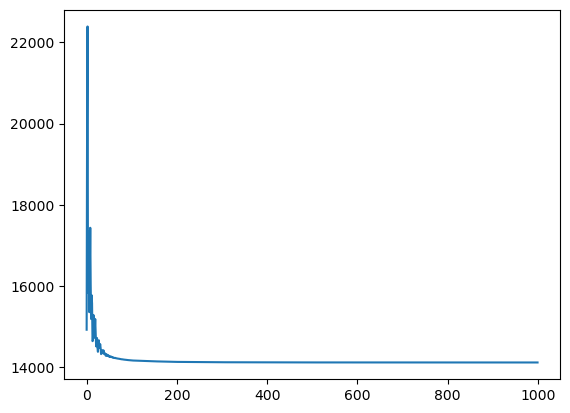

In [547]:
plt.plot(loss_list)

(480000, 3)


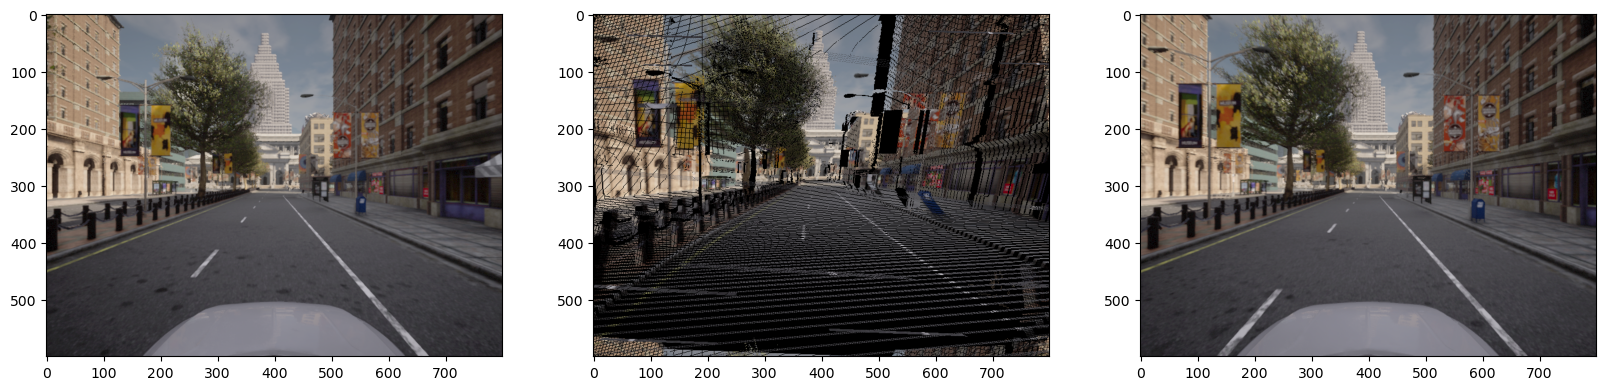

In [548]:
tempq3 = (Tqr.detach().cpu().numpy()@(np.concatenate([point1, np.ones((point1.shape[0], 1))], axis=1).T)).T
tempq3 = tempq3[:, :3]/tempq3[:, [-1]]

tempp3Image,tempp3Image_color= point_to_image(tempq3,intrinsic,height=im2.shape[0],width = im2.shape[1],color =color2)

fig,ax = plt.subplots(1,3,figsize=(20,20))
ax[1].imshow(tempp3Image_color)
ax[2].imshow(im2)
ax[0].imshow(im1)

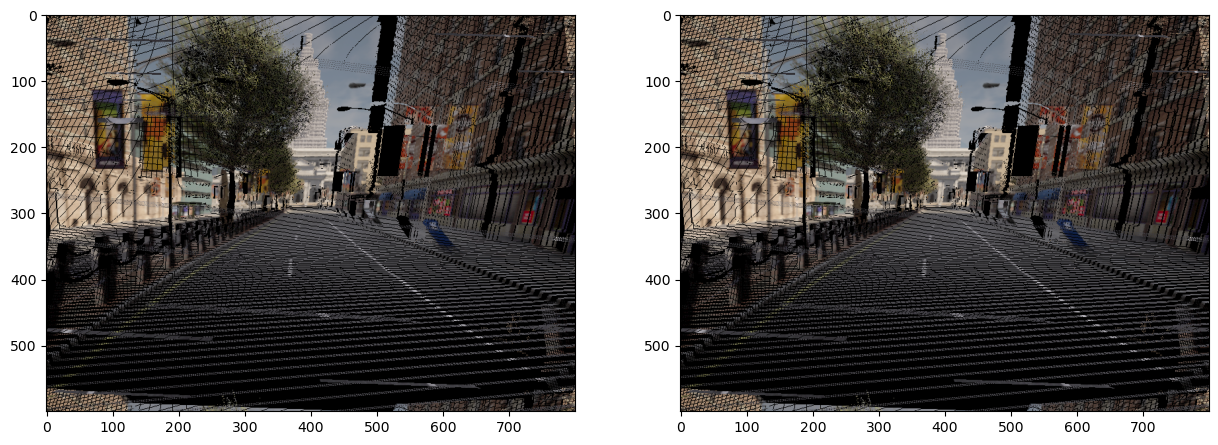

In [509]:
fig2,ax2 = plt.subplots(1,2,figsize=(15,15))
ax2[0].imshow(tempp2Image_color)
ax2[1].imshow(tempp3Image_color)

In [540]:
#sanity check, project u to u', same image

imageC =im1
imagegt = im1
depthC = depth1
depthgt = depth1
intrinsicC = intrinsic
extrinsicC = extrinsic1
extrinsicgt = extrinsic1

pointC,colorC = image_to_point(imageC, intrinsicC, depthC)
point_C_inverseE = inverse_E_point(pointC,extrinsicC)
point_C_project = extrinsicgt@np.concatenate([point_C_inverseE, np.ones((point_C_inverseE.shape[0], 1))], axis=1).T
point_C_project = point_C_project.T[:, :3]
point_C_inverseE_projected,colorC_projected = point_to_image(point_C_project,intrinsicC,height=imageC.shape[0],width = imageC.shape[1],color =colorC)

# pointgt,colorgt = image_to_point(imagegt, intrinsicC, depthgt)


In [538]:
pointC

array([[-419.60784314, -314.70588235,  419.60784314],
       [-419.60784314, -313.65686275,  419.60784314],
       [-419.60784314, -312.60784314,  419.60784314],
       ...,
       [   1.95098039,    4.87254902,    3.92156863],
       [   1.95098039,    4.88235294,    3.92156863],
       [   1.95098039,    4.89215686,    3.92156863]])

In [542]:
import open3d as o3d
pcd_o3d = o3d.geometry.PointCloud()  
pcd_o3d.points = o3d.utility.Vector3dVector(pointC)  
pcd_o3d.colors = o3d.utility.Vector3dVector(color1)  
# Visualize:
o3d.visualization.draw_geometries([pcd_o3d])

In [336]:
point_C_project

array([[-0.41960784, -0.31470588,  0.41960784],
       [-0.41960784, -0.31365686,  0.41960784],
       [-0.41960784, -0.31260784,  0.41960784],
       ...,
       [ 0.00195098,  0.00487255,  0.00392157],
       [ 0.00195098,  0.00488235,  0.00392157],
       [ 0.00195098,  0.00489216,  0.00392157]])

In [522]:
intrinsic

array([[400.,   0., 400.],
       [  0., 400., 300.],
       [  0.,   0.,   1.]])

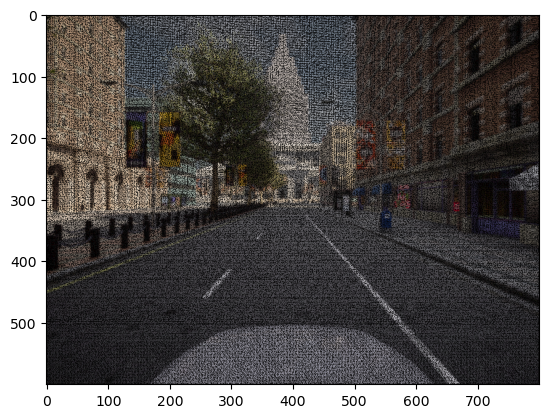

In [519]:
plt.imshow(colorC_projected)
plt.imsave('colorC_projected.png',colorC_projected)

In [68]:
#oivio
import os
print(os.getcwd())
im1 = cv2.cvtColor(cv2.imread(r'C:\Users\28340\Documents\UCL\finalYearProject\dataset\MN_015_HH_01\MN_015_HH_01\handheld0\cam0\data\1552660900894917888.png'), cv2.COLOR_BGR2RGB)

c:\Users\28340\Documents\UCL\finalYearProject\code
